In [5]:
using AirBorne.ETL.YFinance: get_interday_data
using Dates: DateTime,datetime2unix
using RollingFunctions: rolling
using Statistics
using StatsBase
using Plots
using LinearAlgebra
using ToeplitzMatrices
using Random
using Distributions


function apply_differencing(s, d=1)
    differenced_series = s
    init_vals = []
    for i in 1:d
        push!(init_vals, differenced_series[1])
        differenced_series = diff(differenced_series)
    end
    return differenced_series, init_vals
end
function undo_differencing(s, inits, d=1)
    # assert(d == length(inits), "The number of initial values should be equal to the differencing order")
    undifferenced_series = s
    # println(cumsum(undifferenced_series) .+ 6)
    for i in 1:d
        current_init = pop!(inits) # pop the last element
        undifferenced_series = [current_init; cumsum(undifferenced_series) .+ current_init]
    end
    return undifferenced_series
end

function arima(series, p, d, q, F)
    # Apply differencing
    differenced_series, inits = apply_differencing(series, d)
    # Calculate the autocorrelation matrix
    autocorr = autocor(differenced_series)
    # Create the Toeplitz matrix
    R_matrix = Toeplitz(autocorr[1:p], autocorr[1:p])
    r_vector = autocorr[2:p+1]
    # Solve the Yule-Walker equations
    ar_coeffs = R_matrix \ r_vector

    ar_predictions = zeros(F)
    ar_series = differenced_series
    for i in 1:F
        ar_predictions[i] = sum(ar_series[end-p+1:end] .* reverse(ar_coeffs))
        ar_series = [ar_series; ar_predictions[i]]
    end

    ma_coeffs = fill(-0.5, q) # Need to  be tuned
    ma_coeff0 = -0.5 # Need to be tuned
    ma_var = 1 # Need to be tuned
    ma_samples = rand(Normal(0, ma_var), q + F)
    ma_predictions = zeros(F)
    for i in 1:F
        ma_predictions[i] = sum([ma_coeffs[j] * ma_samples[q+i-j] for j in 1:q]) + ma_coeff0 * ma_samples[q+i]
    end

    # Generate the MA samples
    # Forecast
    forecast = ar_predictions .+ ma_predictions
    # Undo differencing
    restored_series = undo_differencing([differenced_series;  forecast], inits, d)
    return restored_series[end-F+1:end]
end

arima (generic function with 1 method)

[125.06999969482422, 126.36000061035156, 125.0199966430664, 129.6199951171875, 130.14999389648438, 130.72999572753906, 133.49000549316406, 133.41000366210938, 134.75999450683594, 135.94000244140625, 135.2100067138672, 135.27000427246094, 137.8699951171875, 141.11000061035156, 142.52999877929688, 141.86000061035156, 143.9600067138672, 145.92999267578125, 143.0, 144.2899932861328, 145.42999267578125, 150.82000732421875, 154.5, 151.72999572753906, 154.64999389648438, 151.9199981689453, 150.8699951171875, 151.00999450683594, 153.85000610351562, 153.1999969482422, 155.3300018310547, 153.7100067138672, 152.5500030517578, 148.47999572753906, 148.91000366210938, 149.39999389648438, 146.7100067138672, 147.9199981689453, 147.41000366210938, 145.30999755859375, 145.91000366210938, 151.02999877929688, 153.8300018310547, 151.60000610351562, 152.8699951171875, 150.58999633789062, 148.5, 150.47000122070312, 152.58999633789062, 152.99000549316406, 155.85000610351562, 155.0, 157.39999389648438, 159.279

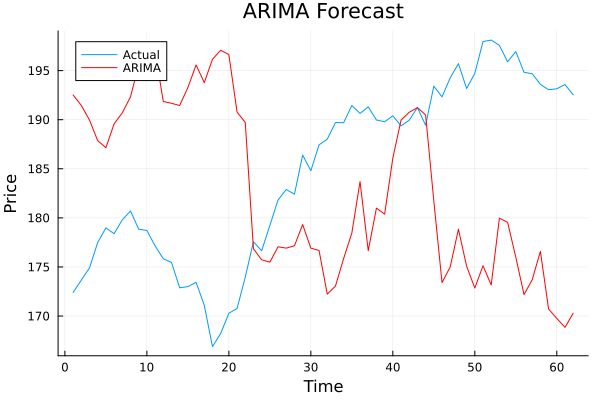

In [27]:
using RollingFunctions
using DirectSearch

unix(x) = string(round(Int, datetime2unix(DateTime(x))))
data = get_interday_data(["AAPL"], unix("2023-01-01"), unix("2024-01-01"))
series = data.close
returns = diff(log.(series))
train_idx = Int(round(length(returns) * 0.5))
valid_idx = Int(round(length(returns) * 0.75))
train, validate, test = returns[1:train_idx], series[train_idx+1:valid_idx], series[valid_idx:end]

println(train)
arima_forecast = arima(train, 2, 2, 0, 4)
println(test[1:10])

forecast = []
for t in 1:1:length(validate)
    all_data = [train; validate[1:t]]
    append!(forecast, arima(all_data, 2, 2, 0, 1))
end
println(length(forecast))
println(length(test))

error = test[2:end] .- forecast[1:end-1]
MSE = mean(error.^2)
println(MSE)

function obj(x)
    p, d, q, F = round.(Int, x)
    println("p: $p, d: $d, q: $q, F: $F")
    expected_length = length(validate) - F
    forecast = []
    for t in 1:F:length(validate)
        all_data = [train;validate[1:t]]
        append!(forecast, arima(all_data, p, d, q, F))
    end
    error = validate[2:expected_length+1] .- forecast[1:expected_length]
    MSE = mean(error.^2)
    println("MSE: $MSE")
    arima_plot = plot(validate[2:expected_length+1], label="Actual", title="ARIMA $(x) Forecast", xlabel="Time", ylabel="Price", legend=:topleft)
    plot!(forecast[1:expected_length], label="Forecast", color=:red)
    savefig(arima_plot, "arima_plots/arima_$(x).svg")
    return MSE
end

problem = DSProblem(4, objective=obj, initial_point=[1, 1, 0, 1], granularity=[1,1,1,1])
condition(x) = (length(test) > x[1] > 0) && (4 >= x[2] >= 0) && (x[3] == 0) && (x[4] > 0)
AddExtremeConstraint(problem, condition)
Optimize!(problem)



# forecast = [arima(s, 2, 2, 0, 3) for s in test[1:3:end]]

arima_plot = plot(test[2:end], label="Actual", title="ARIMA Forecast", xlabel="Time", ylabel="Price", legend=:topleft)
plot!(forecast[1:end-1], label="ARIMA", color=:red)
display(arima_plot)